In [5]:
!pip install rdkit

# Использование обученной в model_pytorch.ipynb модели

## Инициализация и загрузка весов модели, StandartScaler, int_to_char, char_to_int

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

class Config:
    vocab_size = 23
    embedding_dim = 64
    hidden_dim = 256
    latent_dim = 128
    prop_len = 3          # Количество свойств (например, logP, MolWt, QED)
    smiles_len = 69       # Максимальная длина последовательности
    batch_size = 16
    learning_rate = 1e-3
    epochs = 10
    beta = 0.01           # Вес KL дивергенции (KL Annealing factor)

    SOS_TOKEN = 21  # Start of Sequence
    EOS_TOKEN = 22  # End of Sequence
    PAD_TOKEN = 22  # Padding



In [7]:
class MolecularVAE(nn.Module):
    def __init__(self, config):
        super(MolecularVAE, self).__init__()
        self.config = config

        # Encoder
        self.embedding = nn.Embedding(config.vocab_size, config.embedding_dim, padding_idx=config.PAD_TOKEN)
        self.encoder_gru = nn.GRU(config.embedding_dim, config.hidden_dim, batch_first=True)

        self.fc_mu = nn.Linear(config.hidden_dim + config.prop_len, config.latent_dim)
        self.fc_logvar = nn.Linear(config.hidden_dim + config.prop_len, config.latent_dim)

        # Decoder
        self.decoder_init = nn.Linear(config.latent_dim + config.prop_len, config.hidden_dim)
        self.decoder_gru = nn.GRU(config.embedding_dim, config.hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(config.hidden_dim, config.vocab_size)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def forward(self, x_in, properties):
        """
        x_in: (batch, seq_len-1) - входная последовательность (уже без последнего токена)
        properties: (batch, prop_len)
        """
        # --- ENCODER ---
        # В качестве входа энкодера используем x_in (без последнего токена),
        # это стандартная практика, хотя иногда подают и полную последовательность.
        embedded = self.embedding(x_in)
        _, hidden = self.encoder_gru(embedded)
        h_last = hidden[-1]

        # Кондиционирование
        h_conditioned = torch.cat([h_last, properties], dim=1)

        mu = self.fc_mu(h_conditioned)
        logvar = self.fc_logvar(h_conditioned)
        z = self.reparameterize(mu, logvar)

        # --- DECODER ---
        z_conditioned = torch.cat([z, properties], dim=1)
        decoder_hidden_init = self.decoder_init(z_conditioned)
        decoder_hidden = decoder_hidden_init.unsqueeze(0)

        # Teacher Forcing: используем тот же x_in как вход декодера
        dec_emb = self.embedding(x_in)
        dec_output, _ = self.decoder_gru(dec_emb, decoder_hidden)

        logits = self.fc_out(dec_output)
        log_probs = self.log_softmax(logits)

        return log_probs, mu, logvar

In [8]:
import json
import joblib
from google.colab import drive
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDLogger
from rdkit.Chem import Descriptors, Crippen

drive.mount('/content/drive')
model_dir = 'drive/MyDrive/model/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Model:
    def __init__(self):
        if torch.cuda.is_available():
            self.model = torch.load(model_dir + 'model.pth', weights_only=False)
        else:
            self.model = torch.load(model_dir + 'model.pth', weights_only=False, map_location=torch.device('cpu'))
        with open(model_dir + "char_to_int.json", "r", encoding="utf-8") as f:
            self.char_to_int =  json.load(f)
            self.char_to_int = {k: int(v) for k, v in self.char_to_int.items()}
        with open(model_dir + "int_to_char.json", "r", encoding="utf-8") as f:
            self.int_to_char = json.load(f)
            self.int_to_char = {int(k): v for k, v in self.int_to_char.items()}
        self.scaler =  joblib.load(model_dir + 'scaler.joblib')
        self.latent_dim = 128
        self.prop_col = ['Масса , Да', 'Липофильность', 'TPSA']
        self.SOS_TOKEN = self.char_to_int['<']  # Start of Sequence
        self.EOS_TOKEN = self.char_to_int['>'] # End of Sequence
        self.PAD_TOKEN = self.char_to_int['>']  # Padding

    def _generate_smiles(self, properties, max_len=50):
      """
      Генерирует SMILES на основе заданных свойств.
      properties: тензор (1, prop_len) или (batch, prop_len)
      """
      model = self.model
      model.eval()
      with torch.no_grad():
          if properties.dim() == 1:
              properties = properties.unsqueeze(0)

          batch_size = properties.size(0)

          z = torch.randn(batch_size, self.latent_dim).to(device)

          z_conditioned = torch.cat([z, properties], dim=1)
          hidden = model.decoder_init(z_conditioned).unsqueeze(0)

          input_token = torch.tensor([[self.SOS_TOKEN]] * batch_size).to(device) # (batch, 1)

          generated_seqs = []

          for _ in range(max_len):
              embeddings = model.embedding(input_token) # (batch, 1, emb_dim)

              output, hidden = model.decoder_gru(embeddings, hidden)

              logits = model.fc_out(output) # (batch, 1, vocab_size)
              log_prob = model.log_softmax(logits)

              topv, topi = log_prob.topk(1, dim=2)
              next_token = topi.squeeze(2) # (batch, 1)

              generated_seqs.append(next_token.item())

              input_token = next_token

              if next_token.item() == self.EOS_TOKEN:
                  break

          return generated_seqs

    def _prop_scaler(self, prop_str):
        """Принимает строку свойств в виде '400 4 90' и применяет к ним обученный scaler"""
        prop_list = list(map(float, prop_str.split()))
        prop = pd.DataFrame([prop_list], columns=self.prop_col)
        return self.scaler.transform(prop)[0]

    def _is_valid_smile(self, smiles):
        """
        Расширенная проверка валидности SMILES
        Args:
            smiles: SMILES строка
        """
        RDLogger.DisableLog('rdApp.*')
        if smiles is None or smiles == "":
            return False

        try:
            mol = Chem.MolFromSmiles(smiles)

            if mol is None:
                return False
            if mol.GetNumAtoms() == 0:
                return False
            return True
        except:
            return False

    def _int_array_to_smiles(self, int_array):
        """Преобразует массив чисел обратно в SMILES строку"""
        smiles = ''.join([self.int_to_char[i] for i in int_array])
        smiles = smiles.replace('<', '').replace('>', '')
        return smiles

    def get_df_from_smiles(self, smiles):
        """Из массива строк SMILES получает DataFrame с строкой и её свойствами"""
        res = []
        names = ['SMILES', 'Масса', 'Липофильность', 'TPSA']
        for s in smiles:
            mol = Chem.MolFromSmiles(s)
            molecular_weight = Descriptors.MolWt(mol)
            logp = Crippen.MolLogP(mol)
            tpsa = Descriptors.TPSA(mol)

            s_prop = []
            s_prop.append(s)
            s_prop.append(molecular_weight)
            s_prop.append(logp)
            s_prop.append(tpsa)
            res.append(s_prop)
        df = pd.DataFrame(res, columns=names)
        return df


    def generate_n_smiles(self, n=1000, property='400 4 90', max_length=50):
        """
        n: int
        property: str
        max_length: int
        """
        prop_gen = torch.tensor([self._prop_scaler(property)], dtype=torch.float32)
        prop_gen = prop_gen.to(device)
        valid_smiles = []
        for i in range(n):
            smiles_int = self._generate_smiles(prop_gen, max_len=max_length)
            smiles_str = self._int_array_to_smiles(smiles_int)
            if self._is_valid_smile(smiles_str):
                valid_smiles.append(smiles_str)
                mol = Chem.MolFromSmiles(smiles_str)
                molecular_weight = Descriptors.MolWt(mol)
                logp = Crippen.MolLogP(mol)
                tpsa = Descriptors.TPSA(mol)
                print(f"{molecular_weight:.2f}, {logp:.2f}, {tpsa:<10.2f} {smiles_str}")
        print("Валидных SMILES:", f'{len(valid_smiles)}/{n}')
        return valid_smiles


Mounted at /content/drive


In [9]:
gen_model = Model()
smiles = gen_model.generate_n_smiles(1000, '400 4 90', 50)

/tmp/ipython-input-16731132.py:133: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  prop_gen = torch.tensor([self._prop_scaler(property)], dtype=torch.float32)


411.45, 5.76, 67.27      CC(C(O)c1cccc(Nc3ncc(F)c(Oc4ccccc4)n3)c1F)C2(CC2)C
430.43, 5.40, 87.14      CC(C)Cc1ccc(NC(=O)c2ccnc(Nc3ccccc3C(F)(F)F)n2)cc1O
413.38, 5.45, 55.63      c1ccc(Nc2nccc(C(F)(F)F)n2)cc1-c1cnn(C)c1-c1ccccc1F
399.37, 2.40, 153.68     COC(=O)c1cccc(Nc2nccc(C(=O)Nc3cc(C#N)ccn3)n2)c1C#N
436.47, 3.90, 126.50     CC(=O)Nc1ccc(Nc2ccnc(Nc3cc(NC(C)=O)ccc3OC)n2)cc1OC
422.49, 5.59, 87.14      C=C(O)c1ccccc1NC(=O)c1ccnc(Nc2ccc(Cc3ccccc3)cc2)n1
393.37, 4.42, 91.14      Cc1ccc(Nc2nccc(C(F)(F)F)n2)cc1N(C)C(=O)OC(C)(C)C#N
432.50, 4.57, 85.15      N#CC1CCCC1n1c(=O)ccc2cnc(Nc3ccc(F)cc3)nc2N1C1CCCC1
422.41, 5.95, 66.91      FC(F)(F)c1cccc(Nc2nccc(C(=O)Nc3ccc4ccccc4c3)n2)c1C
391.43, 3.92, 97.40      COc1cc(C)cc(Nc2cc(C)nc(Nc3ccc4c(c3)NC(=O)CO4)n2)c1
413.53, 4.17, 66.21      Cc1c(C)cc(Nc2nccc(-c3cccc4c3ccn4C)n2)cc1CN1CC(O)C1
446.56, 5.39, 91.41      CCOC(=O)Nc1ccc(CNc2ccnc(Nc3ccc(N4CCCC4C)cc3)n2)cc1
434.53, 3.95, 119.80     CS(=O)(=O)Nc1cccc(Nc2nccc(NC3CCCc4ccccc43)n2)c1C#N
390.44, 4.30

In [10]:
smiles_df = gen_model.get_df_from_smiles(smiles)
unique_smiles_df = smiles_df.drop_duplicates(subset=['SMILES'])

In [11]:
print(f"Количество уникальных среди сгенерированных: {len(unique_smiles_df)}/{len(smiles_df)}")

Количество уникальных среди сгенерированных: 28/28


In [12]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import MolsToGridImage, rdMolDraw2D, MolsMatrixToGridImage

In [13]:
mols_matrix = []
unique_list = list(unique_smiles_df['SMILES'].values)
for i in range(len(unique_list)//3):
    beg_i = 3 * i
    mols_matrix.append([Chem.MolFromSmiles(smile) for smile in unique_list[beg_i:beg_i + 3]])

print(mols_matrix)

[[<rdkit.Chem.rdchem.Mol object at 0x7f9c953f97e0>, <rdkit.Chem.rdchem.Mol object at 0x7f9c953f9850>, <rdkit.Chem.rdchem.Mol object at 0x7f9c953f98c0>], [<rdkit.Chem.rdchem.Mol object at 0x7f9c953f9930>, <rdkit.Chem.rdchem.Mol object at 0x7f9c953f99a0>, <rdkit.Chem.rdchem.Mol object at 0x7f9c953f9a10>], [<rdkit.Chem.rdchem.Mol object at 0x7f9c953f9a80>, <rdkit.Chem.rdchem.Mol object at 0x7f9c953f9af0>, <rdkit.Chem.rdchem.Mol object at 0x7f9c953f9b60>], [<rdkit.Chem.rdchem.Mol object at 0x7f9c953f9bd0>, <rdkit.Chem.rdchem.Mol object at 0x7f9c953f9c40>, <rdkit.Chem.rdchem.Mol object at 0x7f9c953f9cb0>], [<rdkit.Chem.rdchem.Mol object at 0x7f9c953f9d20>, <rdkit.Chem.rdchem.Mol object at 0x7f9c953f9d90>, <rdkit.Chem.rdchem.Mol object at 0x7f9c953f9e00>], [<rdkit.Chem.rdchem.Mol object at 0x7f9c953f9e70>, <rdkit.Chem.rdchem.Mol object at 0x7f9c953f9ee0>, <rdkit.Chem.rdchem.Mol object at 0x7f9c953f9f50>], [<rdkit.Chem.rdchem.Mol object at 0x7f9c953f9fc0>, <rdkit.Chem.rdchem.Mol object at 0x7

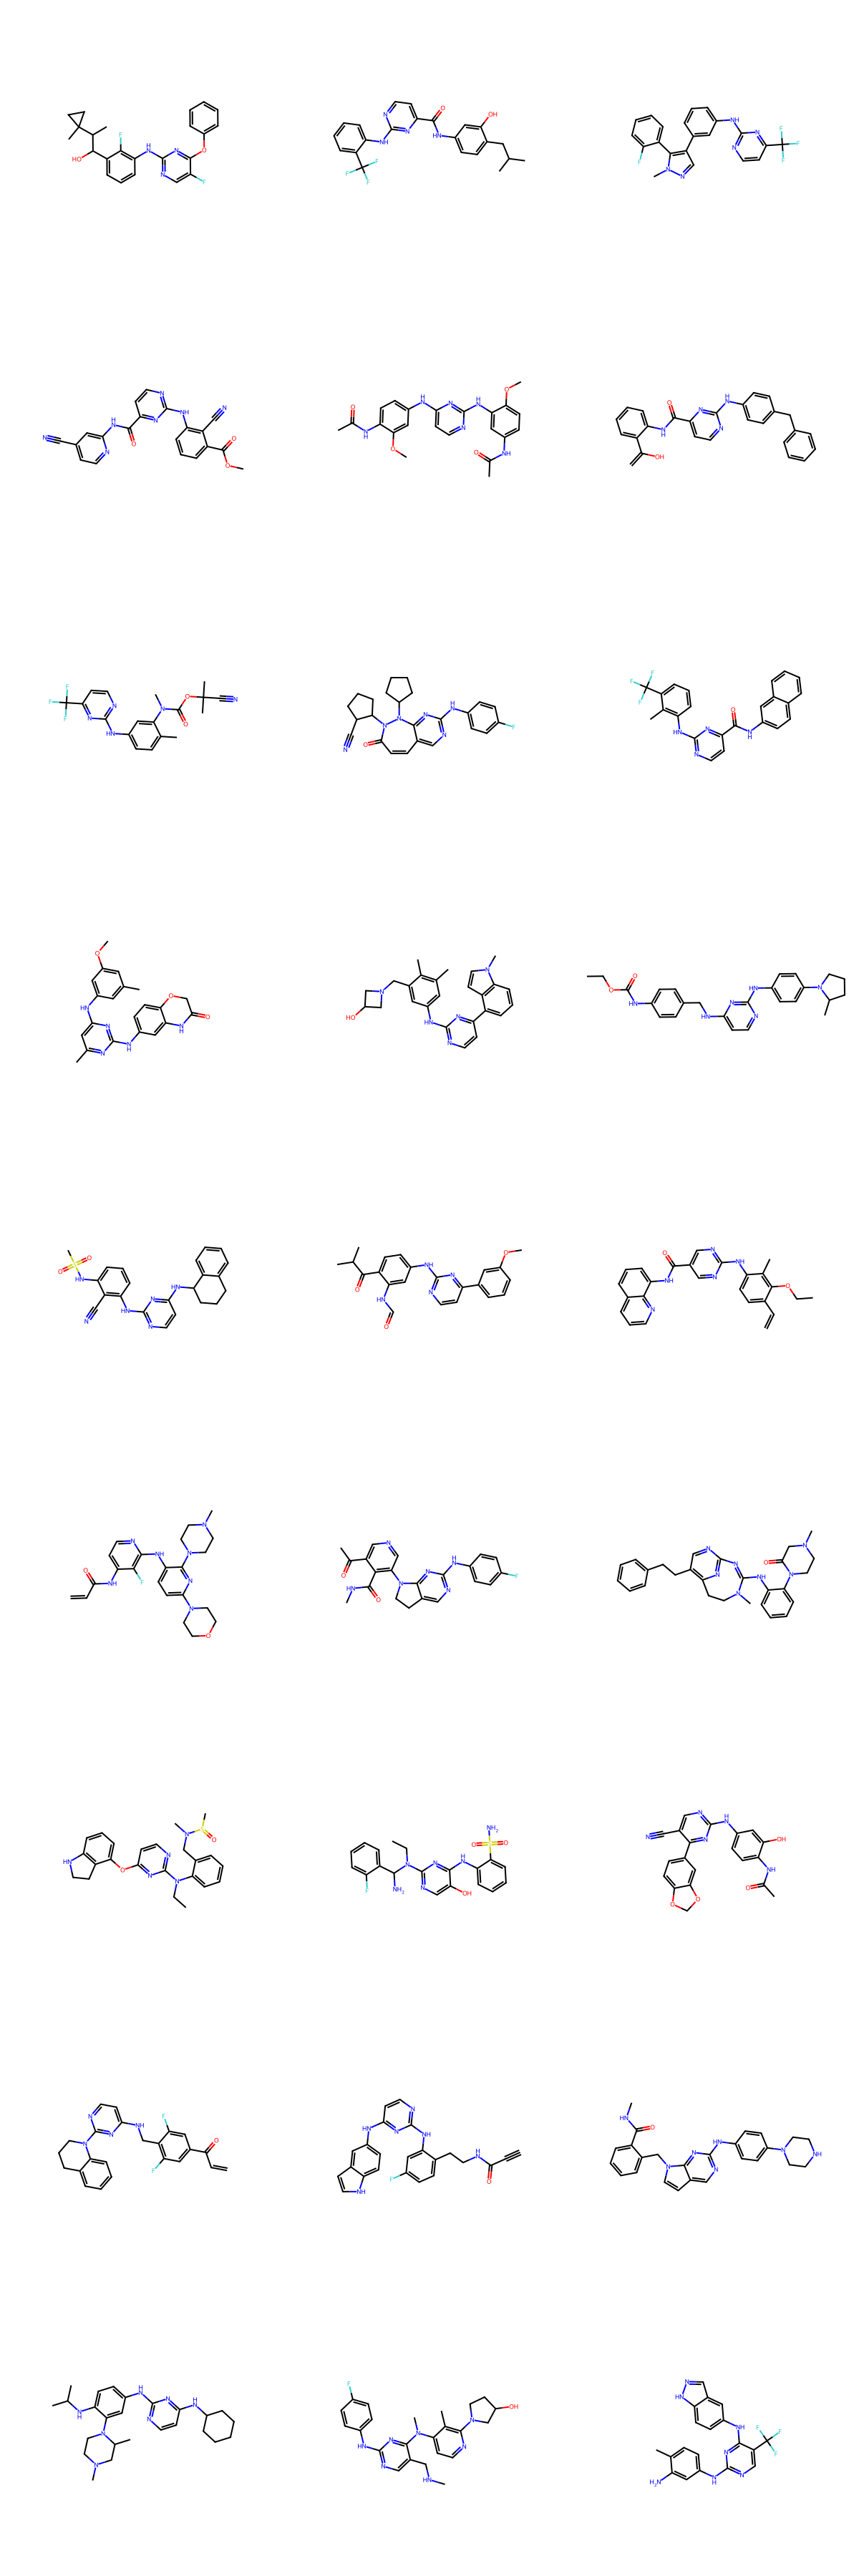

In [14]:
MolsMatrixToGridImage(molsMatrix=mols_matrix,  subImgSize=(400, 400))

## Загрузка оригинального датасета с расчетом энергии связывания

In [15]:
orig_df = pd.read_csv('drive/MyDrive/pyrimidine_smiles_data_energy.csv')

In [16]:
common_smiles = unique_smiles_df['SMILES'].isin(orig_df['smiles']).sum()

print(f"Количество уникальных сгенерированных среди оригинального датасета: {len(unique_smiles_df) - common_smiles}/{len(unique_smiles_df)}")

Количество уникальных сгенерированных среди оригинального датасета: 28/28


In [17]:
for s in smiles:
  print(s)

CC(C(O)c1cccc(Nc3ncc(F)c(Oc4ccccc4)n3)c1F)C2(CC2)C
CC(C)Cc1ccc(NC(=O)c2ccnc(Nc3ccccc3C(F)(F)F)n2)cc1O
c1ccc(Nc2nccc(C(F)(F)F)n2)cc1-c1cnn(C)c1-c1ccccc1F
COC(=O)c1cccc(Nc2nccc(C(=O)Nc3cc(C#N)ccn3)n2)c1C#N
CC(=O)Nc1ccc(Nc2ccnc(Nc3cc(NC(C)=O)ccc3OC)n2)cc1OC
C=C(O)c1ccccc1NC(=O)c1ccnc(Nc2ccc(Cc3ccccc3)cc2)n1
Cc1ccc(Nc2nccc(C(F)(F)F)n2)cc1N(C)C(=O)OC(C)(C)C#N
N#CC1CCCC1n1c(=O)ccc2cnc(Nc3ccc(F)cc3)nc2N1C1CCCC1
FC(F)(F)c1cccc(Nc2nccc(C(=O)Nc3ccc4ccccc4c3)n2)c1C
COc1cc(C)cc(Nc2cc(C)nc(Nc3ccc4c(c3)NC(=O)CO4)n2)c1
Cc1c(C)cc(Nc2nccc(-c3cccc4c3ccn4C)n2)cc1CN1CC(O)C1
CCOC(=O)Nc1ccc(CNc2ccnc(Nc3ccc(N4CCCC4C)cc3)n2)cc1
CS(=O)(=O)Nc1cccc(Nc2nccc(NC3CCCc4ccccc43)n2)c1C#N
CC(C)C(=O)c1ccc(Nc2nccc(-c3cccc(OC)c3)n2)cc1NC(=O)
C=Cc1ccc(Nc2ncc(C(=O)Nc3cccc4cccnc34)cn2)c(C)c1OCC
C=CC(=O)Nc1ccnc(Nc2ccc(N3CCOCC3)nc2N2CCN(C)CC2)c1F
CC(=O)c1cncc(N2CCc3cnc(Nc4ccc(F)cc4)nc32)c1C(=O)NC
CN1CCc2nc(ncc2CCc2ccccc2)nc1Nc1ccccc1N1CCN(C)CC1=O
CCN(c1nccc(Oc2cccc3c2CCN3)n1)c1ccccc1CN(C)S(C)(=O)
CCN(c1ncc(O)c(Nc4ccccc4S(N)(=O)

In [35]:
import numpy as np

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    ape = np.abs((y_true - y_pred) / y_true)
    mape_value = np.mean(ape) * 100
    return mape_value


In [37]:
weight, plog, tpsa = 400, 4, 90

print(f"""Максимальная и минимальная массы: {unique_smiles_df['Масса'].max():.2f}, {unique_smiles_df['Масса'].min():.2f}
Среднее значение массы и отклонение от заданной: {unique_smiles_df['Масса'].mean():.2f}, {abs(unique_smiles_df['Масса'].mean() - weight):.2f}
Функция MAPE: {mape(weight, unique_smiles_df['Масса']):.2f}%

Максимальная и минимальная липофильности: {unique_smiles_df['Липофильность'].max():.2f}, {unique_smiles_df['Липофильность'].min():.2f}
Среднее значение липофильности и отклонение от заданной: {unique_smiles_df['Липофильность'].mean():.2f}, {abs(unique_smiles_df['Липофильность'].mean() - plog):.2f}
Функция MAPE: {mape(plog, unique_smiles_df['Липофильность']):.2f}%

Максимальная и минимальная TPSA: {unique_smiles_df['TPSA'].max():.2f}, {unique_smiles_df['TPSA'].min():.2f}
Среднее значение TPSA и отклонение от заданной: {unique_smiles_df['TPSA'].mean():.2f}, {abs(unique_smiles_df['TPSA'].mean() - tpsa):.2f}
Функция MAPE: {mape(tpsa, unique_smiles_df['TPSA']):.2f}%
""")

Максимальная и минимальная массы: 469.59, 389.37
Среднее значение массы и отклонение от заданной: 422.30, 22.30
Функция MAPE: 6.23%

Максимальная и минимальная липофильности: 5.95, 2.07
Среднее значение липофильности и отклонение от заданной: 4.17, 0.17
Функция MAPE: 22.62%

Максимальная и минимальная TPSA: 153.68, 55.63
Среднее значение TPSA и отклонение от заданной: 91.89, 1.89
Функция MAPE: 19.28%



## Сохранение результата

In [19]:
with open(model_dir + 'res.txt', 'w') as f:
    f.write('\n'.join(smiles))